In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [4]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [9]:
image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [10]:
X_all = []
Y_all = []

image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [11]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [12]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2> V1 !!!!! K-Fold Training and Evaluation</h2>

In [24]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [25]:
model = build_current_model()
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization_60 (Batc (None, 56, 85, 56)        224       
_________________________________________________________________
activation_60 (Activation)   (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 43, 56)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 14, 22, 72)        100

In [37]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.2,
              verbose=2,
              callbacks=my_callbacks)
    
    #for loss,acc plots
    history_info = history.history
    df_history_info = pd.DataFrame(history_info) 
    all_df.append(df_history_info)

    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Epoch 1/100
272/272 - 2s - loss: 1.4273 - accuracy: 0.5368 - val_loss: 1.2559 - val_accuracy: 0.5864
Epoch 2/100
272/272 - 3s - loss: 1.2259 - accuracy: 0.5976 - val_loss: 1.1824 - val_accuracy: 0.6103
Epoch 3/100
272/272 - 2s - loss: 1.0586 - accuracy: 0.6400 - val_loss: 0.9783 - val_accuracy: 0.6489
Epoch 4/100
272/272 - 2s - loss: 0.9107 - accuracy: 0.6971 - val_loss: 1.1649 - val_accuracy: 0.6618
Epoch 5/100
272/272 - 2s - loss: 0.8214 - accuracy: 0.7293 - val_loss: 1.4756 - val_accuracy: 0.5699
Epoch 6/100
272/272 - 2s - loss: 0.7647 - accuracy: 0.7491 - val_loss: 0.6345 - val_accuracy: 0.7886
Epoch 7/100
272/272 - 2s - loss: 0.6844 - accuracy: 0.7772 - val_loss: 0.5965 - val_accuracy: 0.8033
Epoch 8/100
272/272 - 2s - loss: 0.6198 - accuracy: 0.7988 - val_loss: 0.6396 - val_accuracy: 0.7923
Epoch 9/100
272/272 - 2s - loss: 0.5501 - accuracy: 0.8158 - val_loss: 0.4736 - val_accuracy: 0.8419
Epoch 10/100
272/272 - 2s - loss: 0.4943 - accuracy: 0.8343 - val_loss: 0.3798 - val_accura

Epoch 82/100
272/272 - 2s - loss: 0.0964 - accuracy: 0.9687 - val_loss: 0.1056 - val_accuracy: 0.9724
Epoch 83/100
272/272 - 2s - loss: 0.0894 - accuracy: 0.9701 - val_loss: 0.1127 - val_accuracy: 0.9743
Epoch 84/100
272/272 - 2s - loss: 0.0803 - accuracy: 0.9770 - val_loss: 0.1592 - val_accuracy: 0.9522
Epoch 85/100
272/272 - 2s - loss: 0.0952 - accuracy: 0.9719 - val_loss: 0.1360 - val_accuracy: 0.9577
Epoch 86/100
272/272 - 2s - loss: 0.0914 - accuracy: 0.9678 - val_loss: 0.1139 - val_accuracy: 0.9614
Epoch 87/100
272/272 - 2s - loss: 0.0711 - accuracy: 0.9751 - val_loss: 0.0961 - val_accuracy: 0.9706
Epoch 88/100
272/272 - 2s - loss: 0.1039 - accuracy: 0.9715 - val_loss: 0.0912 - val_accuracy: 0.9743
Epoch 89/100
272/272 - 2s - loss: 0.0765 - accuracy: 0.9742 - val_loss: 0.1224 - val_accuracy: 0.9669
Epoch 90/100
272/272 - 2s - loss: 0.0907 - accuracy: 0.9719 - val_loss: 0.1184 - val_accuracy: 0.9724
Epoch 91/100
272/272 - 2s - loss: 0.0748 - accuracy: 0.9765 - val_loss: 0.1432 - v

Epoch 63/100
272/272 - 2s - loss: 0.0959 - accuracy: 0.9682 - val_loss: 0.1119 - val_accuracy: 0.9577
Epoch 64/100
272/272 - 2s - loss: 0.0909 - accuracy: 0.9710 - val_loss: 0.1990 - val_accuracy: 0.9357
Epoch 65/100
272/272 - 2s - loss: 0.1139 - accuracy: 0.9622 - val_loss: 0.1366 - val_accuracy: 0.9632
Epoch 66/100
272/272 - 2s - loss: 0.1213 - accuracy: 0.9567 - val_loss: 0.1763 - val_accuracy: 0.9449
Epoch 67/100
272/272 - 2s - loss: 0.1139 - accuracy: 0.9632 - val_loss: 0.5477 - val_accuracy: 0.8640
Epoch 68/100
272/272 - 2s - loss: 0.1302 - accuracy: 0.9586 - val_loss: 0.1570 - val_accuracy: 0.9522
Epoch 69/100
272/272 - 2s - loss: 0.0990 - accuracy: 0.9641 - val_loss: 0.1316 - val_accuracy: 0.9540
Epoch 70/100
272/272 - 2s - loss: 0.1162 - accuracy: 0.9673 - val_loss: 0.1428 - val_accuracy: 0.9522
Epoch 71/100
272/272 - 2s - loss: 0.1299 - accuracy: 0.9622 - val_loss: 0.0954 - val_accuracy: 0.9669
Epoch 72/100
272/272 - 2s - loss: 0.0970 - accuracy: 0.9696 - val_loss: 0.1462 - v

Epoch 46/100
272/272 - 2s - loss: 0.1520 - accuracy: 0.9475 - val_loss: 0.0841 - val_accuracy: 0.9779
Epoch 47/100
272/272 - 1s - loss: 0.1631 - accuracy: 0.9489 - val_loss: 0.1070 - val_accuracy: 0.9632
Epoch 48/100
272/272 - 2s - loss: 0.1349 - accuracy: 0.9622 - val_loss: 0.1494 - val_accuracy: 0.9577
Epoch 49/100
272/272 - 2s - loss: 0.1494 - accuracy: 0.9475 - val_loss: 0.1986 - val_accuracy: 0.9412
Epoch 50/100
272/272 - 1s - loss: 0.1498 - accuracy: 0.9549 - val_loss: 0.0926 - val_accuracy: 0.9743
Epoch 51/100
272/272 - 2s - loss: 0.1549 - accuracy: 0.9512 - val_loss: 0.2689 - val_accuracy: 0.9283
Epoch 52/100
272/272 - 2s - loss: 0.1437 - accuracy: 0.9530 - val_loss: 0.2119 - val_accuracy: 0.9320
Epoch 53/100
272/272 - 2s - loss: 0.1570 - accuracy: 0.9544 - val_loss: 0.1183 - val_accuracy: 0.9651
Epoch 54/100
272/272 - 2s - loss: 0.1478 - accuracy: 0.9558 - val_loss: 0.0768 - val_accuracy: 0.9779
Epoch 55/100
272/272 - 2s - loss: 0.1301 - accuracy: 0.9553 - val_loss: 0.1427 - v

Epoch 39/100
272/272 - 2s - loss: 0.1747 - accuracy: 0.9424 - val_loss: 0.1394 - val_accuracy: 0.9485
Epoch 40/100
272/272 - 2s - loss: 0.1571 - accuracy: 0.9507 - val_loss: 0.1205 - val_accuracy: 0.9559
Epoch 41/100
272/272 - 2s - loss: 0.2130 - accuracy: 0.9291 - val_loss: 0.1631 - val_accuracy: 0.9449
Epoch 42/100
272/272 - 2s - loss: 0.1540 - accuracy: 0.9494 - val_loss: 0.1113 - val_accuracy: 0.9577
Epoch 43/100
272/272 - 2s - loss: 0.1484 - accuracy: 0.9526 - val_loss: 0.0943 - val_accuracy: 0.9669
Epoch 44/100
272/272 - 2s - loss: 0.1779 - accuracy: 0.9438 - val_loss: 0.1213 - val_accuracy: 0.9540
Epoch 45/100
272/272 - 2s - loss: 0.1650 - accuracy: 0.9461 - val_loss: 0.2276 - val_accuracy: 0.9246
Epoch 46/100
272/272 - 2s - loss: 0.1800 - accuracy: 0.9406 - val_loss: 0.1418 - val_accuracy: 0.9559
Epoch 47/100
272/272 - 2s - loss: 0.1543 - accuracy: 0.9526 - val_loss: 0.0894 - val_accuracy: 0.9743
Epoch 48/100
272/272 - 2s - loss: 0.1458 - accuracy: 0.9507 - val_loss: 0.0806 - v

Epoch 20/100
272/272 - 2s - loss: 0.3001 - accuracy: 0.9065 - val_loss: 0.2268 - val_accuracy: 0.9301
Epoch 21/100
272/272 - 2s - loss: 0.3025 - accuracy: 0.8992 - val_loss: 0.2103 - val_accuracy: 0.9375
Epoch 22/100
272/272 - 2s - loss: 0.2823 - accuracy: 0.9144 - val_loss: 0.1992 - val_accuracy: 0.9375
Epoch 23/100
272/272 - 2s - loss: 0.2731 - accuracy: 0.9047 - val_loss: 0.2169 - val_accuracy: 0.9283
Epoch 24/100
272/272 - 2s - loss: 0.2487 - accuracy: 0.9176 - val_loss: 0.2289 - val_accuracy: 0.9375
Epoch 25/100
272/272 - 2s - loss: 0.2973 - accuracy: 0.9038 - val_loss: 0.2119 - val_accuracy: 0.9301
Epoch 26/100
272/272 - 2s - loss: 0.2364 - accuracy: 0.9213 - val_loss: 0.2427 - val_accuracy: 0.9210
Epoch 27/100
272/272 - 2s - loss: 0.2438 - accuracy: 0.9190 - val_loss: 0.2518 - val_accuracy: 0.9136
Epoch 28/100
272/272 - 2s - loss: 0.2355 - accuracy: 0.9203 - val_loss: 0.1780 - val_accuracy: 0.9393
Epoch 29/100
272/272 - 1s - loss: 0.2114 - accuracy: 0.9365 - val_loss: 0.2054 - v

Epoch 1/100
272/272 - 2s - loss: 1.4096 - accuracy: 0.5442 - val_loss: 1.4527 - val_accuracy: 0.5294
Epoch 2/100
272/272 - 2s - loss: 1.2140 - accuracy: 0.6077 - val_loss: 1.2282 - val_accuracy: 0.6011
Epoch 3/100
272/272 - 2s - loss: 1.1178 - accuracy: 0.6294 - val_loss: 1.0288 - val_accuracy: 0.6250
Epoch 4/100
272/272 - 1s - loss: 0.9680 - accuracy: 0.6740 - val_loss: 0.8890 - val_accuracy: 0.6636
Epoch 5/100
272/272 - 2s - loss: 0.8743 - accuracy: 0.7136 - val_loss: 0.8279 - val_accuracy: 0.6967
Epoch 6/100
272/272 - 2s - loss: 0.7697 - accuracy: 0.7399 - val_loss: 0.8133 - val_accuracy: 0.7335
Epoch 7/100
272/272 - 2s - loss: 0.6931 - accuracy: 0.7804 - val_loss: 0.5721 - val_accuracy: 0.8180
Epoch 8/100
272/272 - 2s - loss: 0.6377 - accuracy: 0.7919 - val_loss: 0.5989 - val_accuracy: 0.8070
Epoch 9/100
272/272 - 2s - loss: 0.5382 - accuracy: 0.8246 - val_loss: 0.3807 - val_accuracy: 0.8842
Epoch 10/100
272/272 - 2s - loss: 0.5373 - accuracy: 0.8301 - val_loss: 0.4922 - val_accura

Epoch 11/100
272/272 - 2s - loss: 0.4744 - accuracy: 0.8425 - val_loss: 0.4381 - val_accuracy: 0.8676
Epoch 12/100
272/272 - 2s - loss: 0.4723 - accuracy: 0.8458 - val_loss: 0.4577 - val_accuracy: 0.8419
Epoch 13/100
272/272 - 2s - loss: 0.4343 - accuracy: 0.8573 - val_loss: 0.3326 - val_accuracy: 0.8934
Epoch 14/100
272/272 - 2s - loss: 0.4186 - accuracy: 0.8633 - val_loss: 0.4790 - val_accuracy: 0.8143
Epoch 15/100
272/272 - 2s - loss: 0.3850 - accuracy: 0.8651 - val_loss: 0.3536 - val_accuracy: 0.8713
Epoch 16/100
272/272 - 2s - loss: 0.3767 - accuracy: 0.8679 - val_loss: 0.3895 - val_accuracy: 0.8511
Epoch 17/100
272/272 - 2s - loss: 0.3413 - accuracy: 0.8867 - val_loss: 0.7435 - val_accuracy: 0.8088
Epoch 18/100
272/272 - 1s - loss: 0.3489 - accuracy: 0.8817 - val_loss: 0.2502 - val_accuracy: 0.9099
Epoch 19/100
272/272 - 2s - loss: 0.3114 - accuracy: 0.8969 - val_loss: 0.2409 - val_accuracy: 0.9136
Epoch 20/100
272/272 - 2s - loss: 0.3502 - accuracy: 0.8881 - val_loss: 0.2286 - v

Epoch 12/100
272/272 - 2s - loss: 0.4951 - accuracy: 0.8389 - val_loss: 0.5303 - val_accuracy: 0.8180
Epoch 13/100
272/272 - 2s - loss: 0.4757 - accuracy: 0.8389 - val_loss: 0.3044 - val_accuracy: 0.8842
Epoch 14/100
272/272 - 2s - loss: 0.4308 - accuracy: 0.8600 - val_loss: 0.3730 - val_accuracy: 0.8695
Epoch 15/100
272/272 - 2s - loss: 0.4079 - accuracy: 0.8568 - val_loss: 0.3184 - val_accuracy: 0.8989
Epoch 16/100
272/272 - 1s - loss: 0.4252 - accuracy: 0.8554 - val_loss: 0.3076 - val_accuracy: 0.8805
Epoch 17/100
272/272 - 2s - loss: 0.3724 - accuracy: 0.8798 - val_loss: 0.3037 - val_accuracy: 0.8897
Epoch 18/100
272/272 - 2s - loss: 0.3536 - accuracy: 0.8821 - val_loss: 0.3356 - val_accuracy: 0.8842
Epoch 19/100
272/272 - 1s - loss: 0.3482 - accuracy: 0.8817 - val_loss: 0.2143 - val_accuracy: 0.9173
Epoch 20/100
272/272 - 2s - loss: 0.3446 - accuracy: 0.8895 - val_loss: 0.2076 - val_accuracy: 0.9265
Epoch 21/100
272/272 - 2s - loss: 0.3370 - accuracy: 0.8858 - val_loss: 0.2862 - v

Epoch 93/100
272/272 - 2s - loss: 0.0794 - accuracy: 0.9788 - val_loss: 0.1190 - val_accuracy: 0.9706
Epoch 94/100
272/272 - 2s - loss: 0.1333 - accuracy: 0.9613 - val_loss: 0.1086 - val_accuracy: 0.9669
Epoch 95/100
272/272 - 2s - loss: 0.0920 - accuracy: 0.9705 - val_loss: 0.0995 - val_accuracy: 0.9669
Epoch 96/100
272/272 - 2s - loss: 0.0713 - accuracy: 0.9784 - val_loss: 0.1132 - val_accuracy: 0.9706
Epoch 97/100
272/272 - 2s - loss: 0.0689 - accuracy: 0.9788 - val_loss: 0.1170 - val_accuracy: 0.9688
Epoch 98/100
272/272 - 1s - loss: 0.0599 - accuracy: 0.9802 - val_loss: 0.1284 - val_accuracy: 0.9688
Epoch 99/100
272/272 - 2s - loss: 0.0876 - accuracy: 0.9692 - val_loss: 0.1339 - val_accuracy: 0.9651
Epoch 100/100
272/272 - 2s - loss: 0.0927 - accuracy: 0.9664 - val_loss: 0.1250 - val_accuracy: 0.9688
Epoch 1/100
272/272 - 2s - loss: 1.4283 - accuracy: 0.5246 - val_loss: 1.2604 - val_accuracy: 0.6176
Epoch 2/100
272/272 - 1s - loss: 1.1785 - accuracy: 0.6111 - val_loss: 1.1128 - va

Epoch 74/100
272/272 - 2s - loss: 0.0891 - accuracy: 0.9678 - val_loss: 0.0649 - val_accuracy: 0.9779
Epoch 75/100
272/272 - 2s - loss: 0.1009 - accuracy: 0.9636 - val_loss: 0.0834 - val_accuracy: 0.9706
Epoch 76/100
272/272 - 2s - loss: 0.1088 - accuracy: 0.9673 - val_loss: 0.0967 - val_accuracy: 0.9632
Epoch 77/100
272/272 - 2s - loss: 0.0860 - accuracy: 0.9715 - val_loss: 0.0792 - val_accuracy: 0.9724
Epoch 78/100
Restoring model weights from the end of the best epoch.
272/272 - 2s - loss: 0.0905 - accuracy: 0.9715 - val_loss: 0.0655 - val_accuracy: 0.9798
Epoch 00078: early stopping
Epoch 1/100
272/272 - 2s - loss: 1.4663 - accuracy: 0.5370 - val_loss: 1.3599 - val_accuracy: 0.5938
Epoch 2/100
272/272 - 2s - loss: 1.2355 - accuracy: 0.5964 - val_loss: 1.1301 - val_accuracy: 0.6029
Epoch 3/100
272/272 - 2s - loss: 1.0791 - accuracy: 0.6461 - val_loss: 0.9111 - val_accuracy: 0.6544
Epoch 4/100
272/272 - 2s - loss: 0.9515 - accuracy: 0.6820 - val_loss: 0.8339 - val_accuracy: 0.7004
Ep

Epoch 76/100
272/272 - 2s - loss: 0.1151 - accuracy: 0.9632 - val_loss: 0.1076 - val_accuracy: 0.9651
Epoch 77/100
272/272 - 2s - loss: 0.0943 - accuracy: 0.9696 - val_loss: 0.1300 - val_accuracy: 0.9669
Epoch 78/100
272/272 - 2s - loss: 0.0652 - accuracy: 0.9798 - val_loss: 0.1155 - val_accuracy: 0.9688
Epoch 79/100
272/272 - 2s - loss: 0.1090 - accuracy: 0.9669 - val_loss: 0.1175 - val_accuracy: 0.9669
Epoch 80/100
272/272 - 2s - loss: 0.0920 - accuracy: 0.9742 - val_loss: 0.1355 - val_accuracy: 0.9688
Epoch 81/100
272/272 - 2s - loss: 0.0866 - accuracy: 0.9724 - val_loss: 0.1389 - val_accuracy: 0.9669
Epoch 82/100
272/272 - 2s - loss: 0.0877 - accuracy: 0.9733 - val_loss: 0.1499 - val_accuracy: 0.9651
Epoch 83/100
272/272 - 2s - loss: 0.0714 - accuracy: 0.9738 - val_loss: 0.0927 - val_accuracy: 0.9761
Epoch 84/100
272/272 - 2s - loss: 0.0871 - accuracy: 0.9747 - val_loss: 0.1254 - val_accuracy: 0.9632
Epoch 85/100
272/272 - 2s - loss: 0.0839 - accuracy: 0.9761 - val_loss: 0.1479 - v

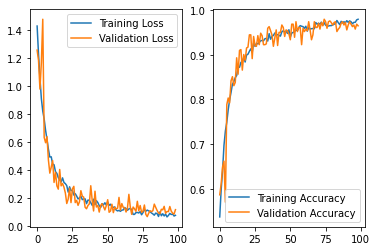

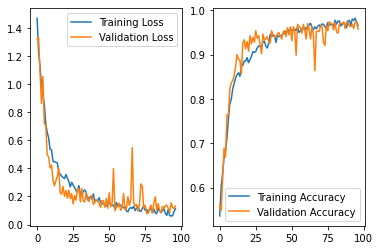

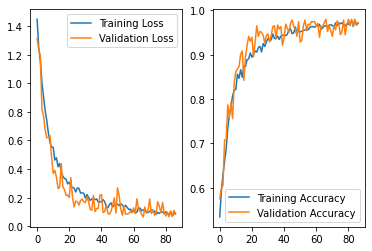

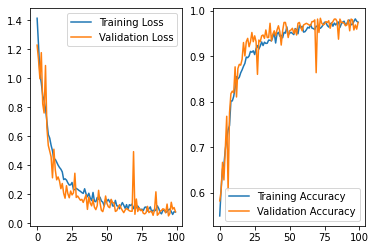

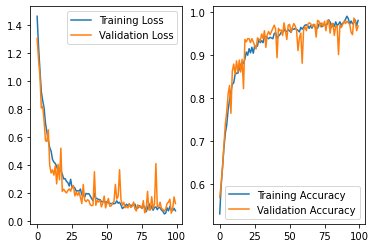

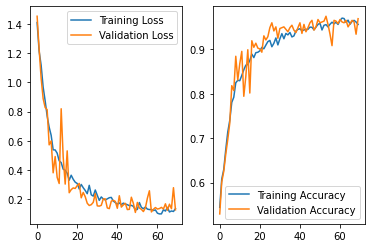

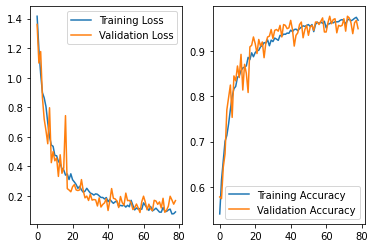

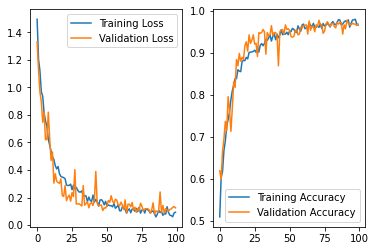

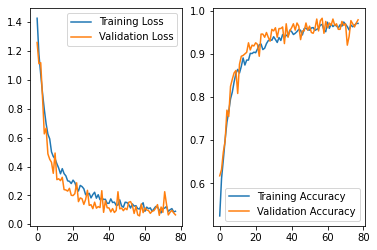

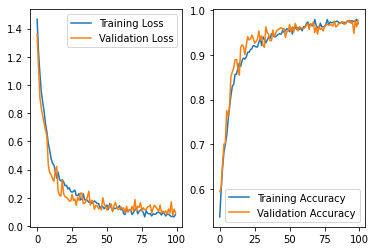

In [38]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [39]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.91025641 0.94590909 0.96710143 0.98518822 0.96641301
 0.86402264 0.96865128]
precision sdev by class [0.         0.06151093 0.05807617 0.02825144 0.01267936 0.03819539
 0.08735437 0.02806238]
macro precision mean 0.9509427606120819
macro precision sdev 0.01405793441531623
recall mean [0.93333333 0.94487179 0.875      0.95655172 0.98678667 0.94814815
 0.93397436 0.96512195]
recall sdev [0.2        0.04991775 0.05957937 0.0448211  0.00587751 0.04743055
 0.04982299 0.02777544]
macro recall mean 0.9429734972892095
macro recall sdev 0.024422710599660863
f1 mean [0.95       0.92578632 0.90745153 0.96107406 0.98592469 0.95678769
 0.89482522 0.96642238]
f1 sdev [0.15       0.04349297 0.04418399 0.02829712 0.00607334 0.03879896
 0.05338265 0.01845859]
macro f1 mean 0.9435339867888646
macro f1 sdev 0.02164684882176006
accuracy mean 0.9688455699544564
accuracy sdev 0.009771194733172514


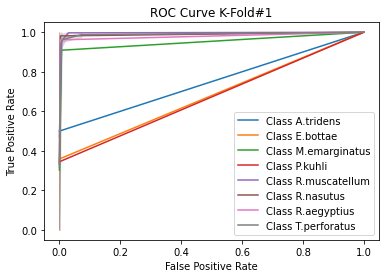

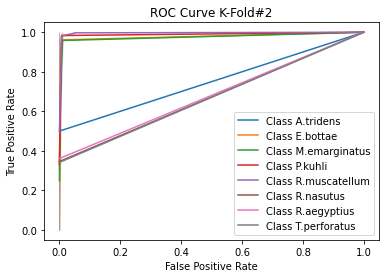

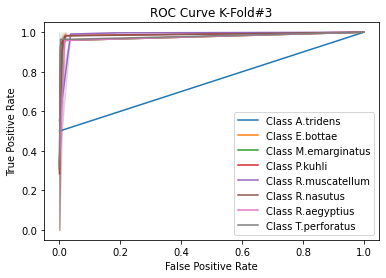

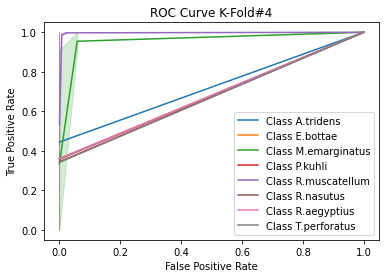

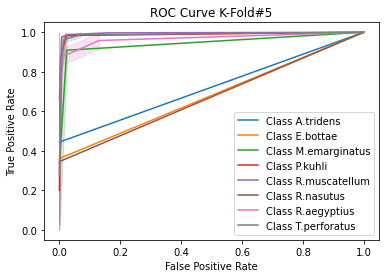

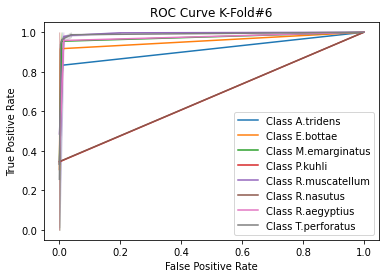

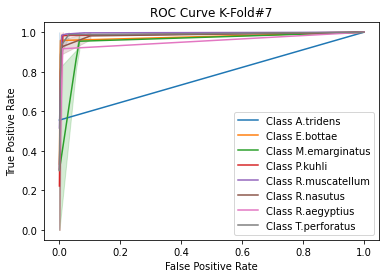

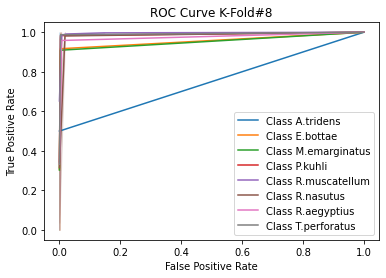

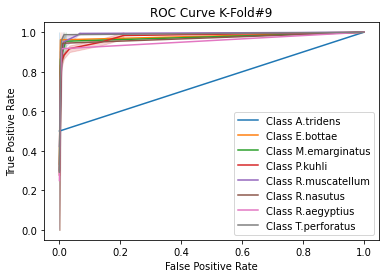

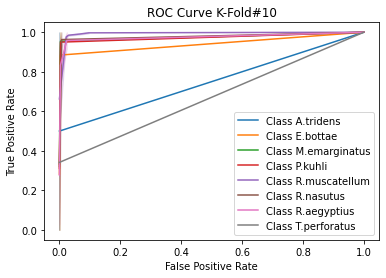

In [40]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')
        

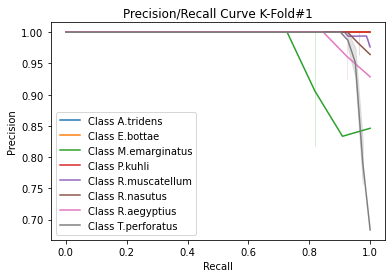

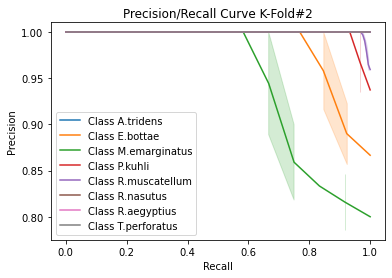

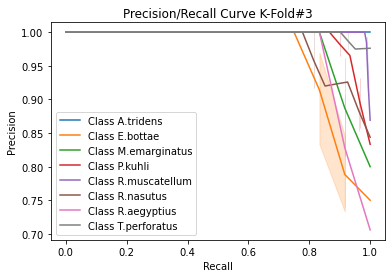

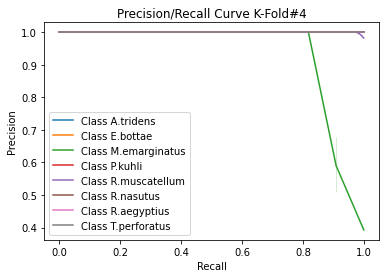

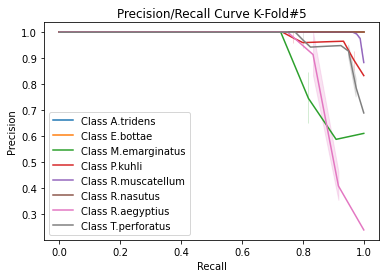

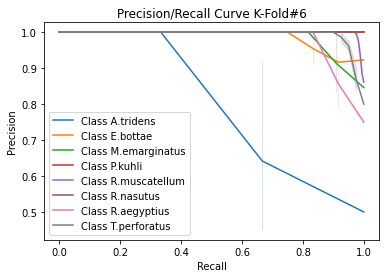

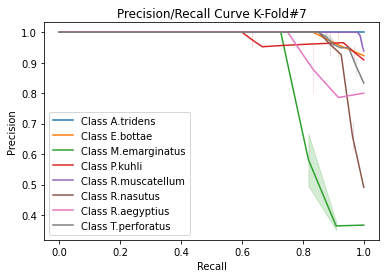

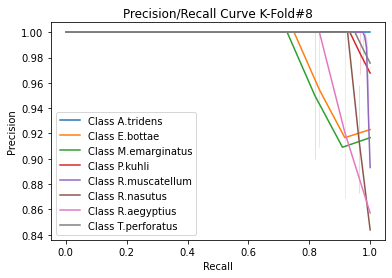

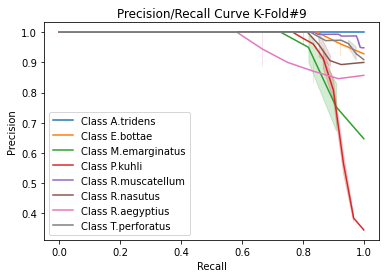

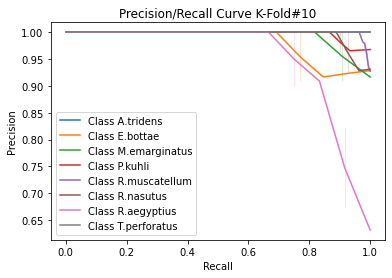

In [41]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   1   0   0]
 [  0   0   9   0   0   0   0   2]
 [  0   0   0  28   1   0   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   0   0   0   1  26   0   0]
 [  0   0   1   0   0   0  12   0]
 [  0   0   0   0   2   0   0  39]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   1   0]
 [  0   0  10   0   0   0   2   0]
 [  0   0   1  28   1   0   0   0]
 [  0   2   1   0 163   0   0   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  11   0   0   0   0   1]
 [  0   0   0  29   0   1   0   0]
 [  0   0   0   1 164   0   0   1]
 [  0   3   0   1   0  23   0   0]
 [  0   0   0   0   0   0  11   1]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

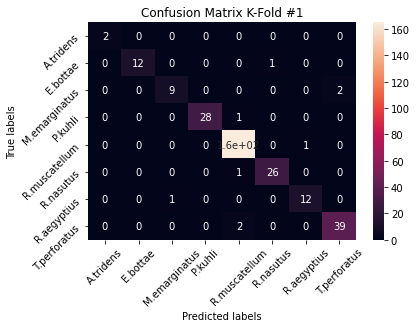

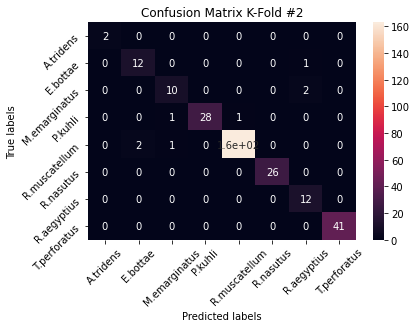

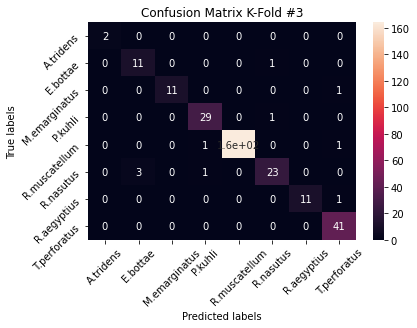

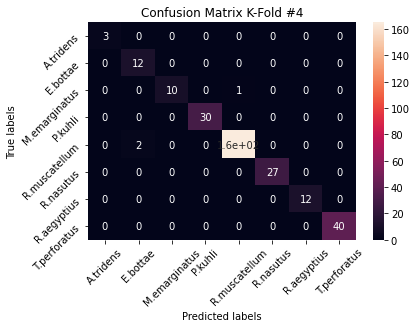

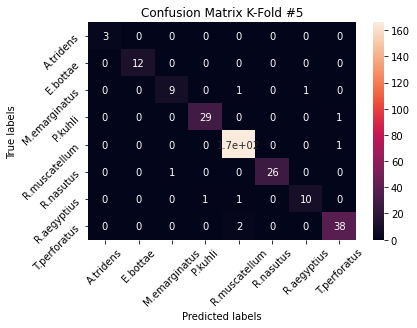

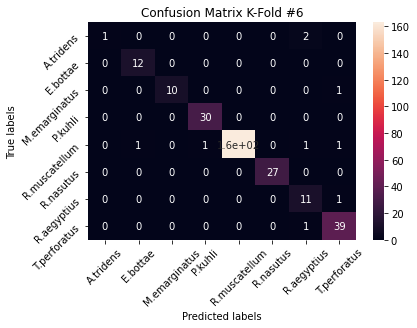

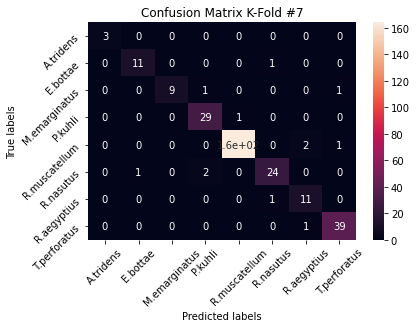

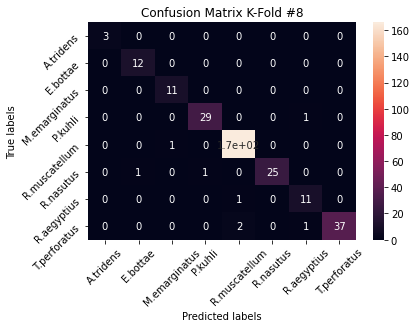

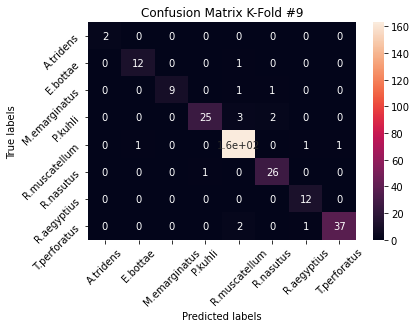

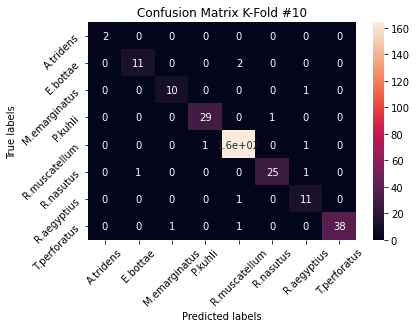

In [42]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  117    0    0    3    3    1    0]
 [   0    0   98    1    3    1    4    5]
 [   0    0    1  286    6    4    1    1]
 [   0    6    2    3 1643    0    6    5]
 [   0    6    1    5    1  255    1    0]
 [   0    0    1    1    3    1  113    2]
 [   0    0    1    0    9    0    4  389]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  38]]


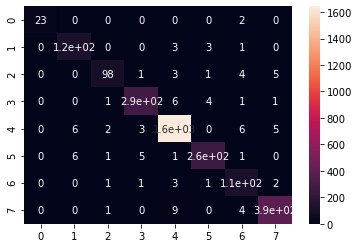

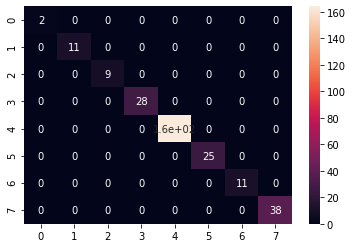

In [43]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.94 0.   0.   0.02 0.02 0.01 0.  ]
 [0.   0.   0.88 0.01 0.03 0.01 0.04 0.04]
 [0.   0.   0.   0.96 0.02 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.02 0.   0.02 0.   0.95 0.   0.  ]
 [0.   0.   0.01 0.01 0.02 0.01 0.93 0.02]
 [0.   0.   0.   0.   0.02 0.   0.01 0.97]]


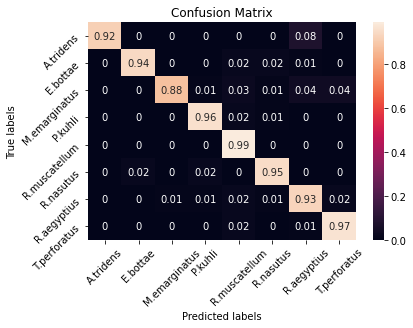

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);